In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns   
from scipy.signal import butter, filtfilt
# import seglearn as sglearn        # For windowing and sequence modeling
import tsfresh     
import os
from sklearn.preprocessing import StandardScaler

 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import polars as pl
import dask.dataframe as dd
from pathlib import Path

# Data Exploration

In [27]:
# File paths for three training datasets
defog = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog')
notype = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype')
tdcsfog = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog')

In [28]:
defog_files = [f for f in os.listdir(defog) if f.endswith('.csv')]

# List to store individual DataFrames
defog_list = []

for path in defog.glob("*.csv"):
    patient_id = path.stem  # removes .csv

    df = pl.read_csv(path)
    df = df.with_columns([
        pl.lit(patient_id).alias("patient_id")
    ])
    
    defog_list.append(df)

defog_df = pl.concat(defog_list)

In [29]:
defog_df.head()

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,patient_id
i64,f64,f64,f64,i64,i64,i64,bool,bool,str
0,-1.002697,0.022371,0.068304,0,0,0,false,false,"""be9d33541d"""
1,-1.002641,0.019173,0.066162,0,0,0,false,false,"""be9d33541d"""
2,-0.99982,0.019142,0.067536,0,0,0,false,false,"""be9d33541d"""
3,-0.998023,0.018378,0.068409,0,0,0,false,false,"""be9d33541d"""
4,-0.998359,0.016726,0.066448,0,0,0,false,false,"""be9d33541d"""


In [30]:
tdcsfog_files = [f for f in os.listdir(tdcsfog) if f.endswith('.csv')]

# List to store individual DataFrames
tdcsfog_list = []

for path in tdcsfog.glob("*.csv"):
    patient_id = path.stem  # removes .csv

    df = pl.read_csv(path)
    df = df.with_columns([
        pl.lit(patient_id).alias("patient_id")
    ])
    
    tdcsfog_list.append(df)

tdcsfog_df = pl.concat(tdcsfog_list)

In [31]:
tdcsfog_df.head()

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id
i64,f64,f64,f64,i64,i64,i64,str
0,-9.66589,0.04255,0.184744,0,0,0,"""a171e61840"""
1,-9.672969,0.049217,0.184644,0,0,0,"""a171e61840"""
2,-9.67026,0.03362,0.19379,0,0,0,"""a171e61840"""
3,-9.673356,0.035159,0.184369,0,0,0,"""a171e61840"""
4,-9.671458,0.043913,0.197814,0,0,0,"""a171e61840"""


In [32]:
print(defog_df.head())
# print(defog_df.info())
print(defog_df.describe())
print(defog_df.shape)     # (rows, columns)
print(defog_df.columns)   # list of column names
print(defog_df.dtypes)    # list of column types

shape: (5, 10)
┌──────┬───────────┬──────────┬──────────┬───┬─────────┬───────┬───────┬────────────┐
│ Time ┆ AccV      ┆ AccML    ┆ AccAP    ┆ … ┆ Walking ┆ Valid ┆ Task  ┆ patient_id │
│ ---  ┆ ---       ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---        │
│ i64  ┆ f64       ┆ f64      ┆ f64      ┆   ┆ i64     ┆ bool  ┆ bool  ┆ str        │
╞══════╪═══════════╪══════════╪══════════╪═══╪═════════╪═══════╪═══════╪════════════╡
│ 0    ┆ -1.002697 ┆ 0.022371 ┆ 0.068304 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 1    ┆ -1.002641 ┆ 0.019173 ┆ 0.066162 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 2    ┆ -0.99982  ┆ 0.019142 ┆ 0.067536 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 3    ┆ -0.998023 ┆ 0.018378 ┆ 0.068409 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 4    ┆ -0.998359 ┆ 0.016726 ┆ 0.066448 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
└──────┴───────────┴──────────┴──────────┴───┴─────────┴───────┴───────┴────────────┘
shape: (9, 11)
┌───────────┬───────────

In [33]:
print(tdcsfog_df.head())
# print(tdcsfog_df.info())
print(tdcsfog_df.shape)     # (rows, columns)
print(tdcsfog_df.columns)   # list of column names
print(tdcsfog_df.dtypes) 
print(tdcsfog_df.describe())

shape: (5, 8)
┌──────┬───────────┬──────────┬──────────┬─────────────────┬──────┬─────────┬────────────┐
│ Time ┆ AccV      ┆ AccML    ┆ AccAP    ┆ StartHesitation ┆ Turn ┆ Walking ┆ patient_id │
│ ---  ┆ ---       ┆ ---      ┆ ---      ┆ ---             ┆ ---  ┆ ---     ┆ ---        │
│ i64  ┆ f64       ┆ f64      ┆ f64      ┆ i64             ┆ i64  ┆ i64     ┆ str        │
╞══════╪═══════════╪══════════╪══════════╪═════════════════╪══════╪═════════╪════════════╡
│ 0    ┆ -9.66589  ┆ 0.04255  ┆ 0.184744 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 1    ┆ -9.672969 ┆ 0.049217 ┆ 0.184644 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 2    ┆ -9.67026  ┆ 0.03362  ┆ 0.19379  ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 3    ┆ -9.673356 ┆ 0.035159 ┆ 0.184369 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 4    ┆ -9.671458 ┆ 0.043913 ┆ 0.197814 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
└──────┴───────────┴──────────┴──────────┴─────────────────┴──────┴─────────

In [34]:
events_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/events.csv')
print(events_df.head())
print(events_df.shape)   
print(events_df.columns)   
print(events_df.dtypes) 
print(events_df.describe())

           Id      Init  Completion  Type  Kinetic
0  003f117e14   8.61312     14.7731  Turn      1.0
1  009ee11563  11.38470     41.1847  Turn      1.0
2  009ee11563  54.66470     58.7847  Turn      1.0
3  011322847a  28.09660     30.2966  Turn      1.0
4  01d0fe7266  30.31840     31.8784  Turn      1.0
(3544, 5)
Index(['Id', 'Init', 'Completion', 'Type', 'Kinetic'], dtype='object')
Id             object
Init          float64
Completion    float64
Type           object
Kinetic       float64
dtype: object
              Init   Completion      Kinetic
count  3544.000000  3544.000000  2502.000000
mean    956.298418   964.489046     0.817746
std     946.357201   943.968560     0.386131
min     -30.669000   -29.719000     0.000000
25%      39.518175    48.610800     1.000000
50%     768.656500   774.261000     1.000000
75%    1570.300000  1576.697250     1.000000
max    4381.217000  4392.745000     1.000000


In [35]:
unique_defog_patients = defog_df["patient_id"].unique()

print(unique_defog_patients)

shape: (91,)
Series: 'patient_id' [str]
[
	"28209b9006"
	"4f613ccf88"
	"3f970065e5"
	"b3891f42d0"
	"afc4b9d2a8"
	…
	"771d69d829"
	"f2ffe15369"
	"f0b8335d50"
	"38befe9f39"
	"5f7c0cfbb5"
]


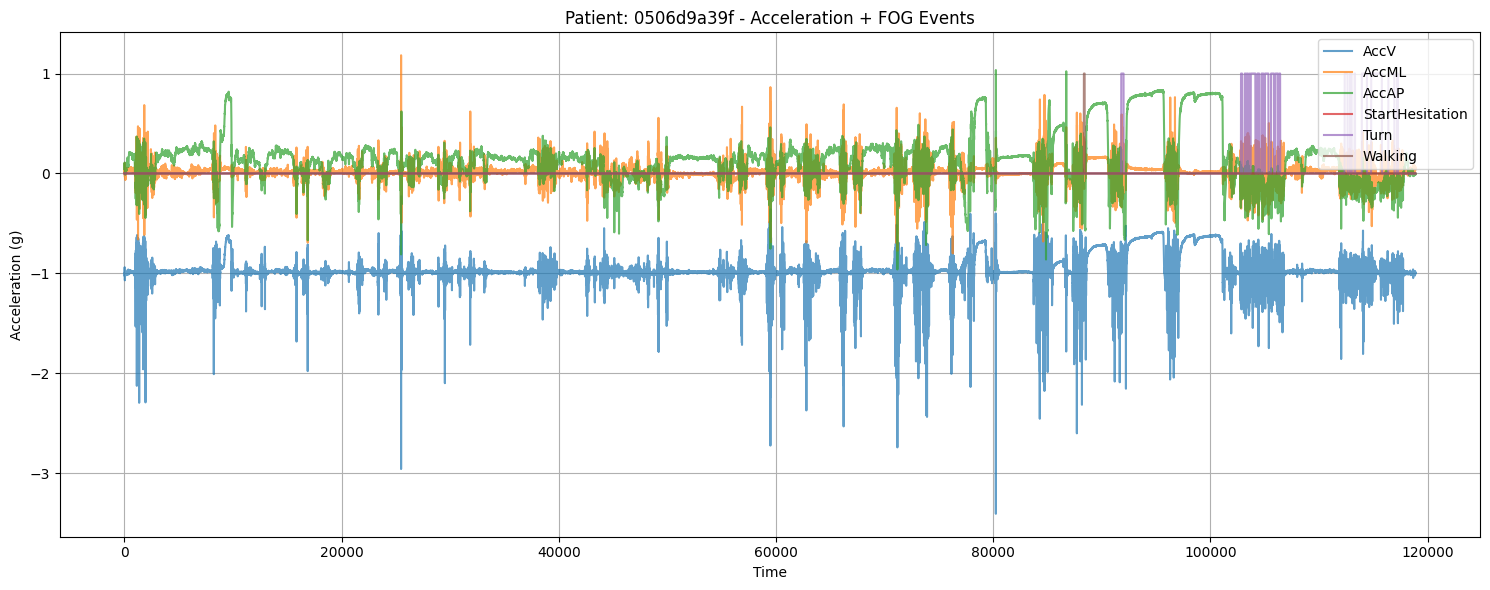

In [36]:
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == 'be9d33541d').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)
plt.plot(df['Time'], df['Turn'], label='Turn', alpha=0.7)
plt.plot(df['Time'], df['Walking'], label='Walking', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Data Cleaning

In [37]:
# Data types of features 
print(f'DEFOG DATA TYPES:\n{defog_df.dtypes}\n')
print(f'TDCSFOG DATA TYPES:\n{tdcsfog_df.dtypes}\n')

DEFOG DATA TYPES:
[Int64, Float64, Float64, Float64, Int64, Int64, Int64, Boolean, Boolean, String]

TDCSFOG DATA TYPES:
[Int64, Float64, Float64, Float64, Int64, Int64, Int64, String]



In [38]:
print(tdcsfog_df.null_count())

shape: (1, 8)
┌──────┬──────┬───────┬───────┬─────────────────┬──────┬─────────┬────────────┐
│ Time ┆ AccV ┆ AccML ┆ AccAP ┆ StartHesitation ┆ Turn ┆ Walking ┆ patient_id │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆ ---             ┆ ---  ┆ ---     ┆ ---        │
│ u32  ┆ u32  ┆ u32   ┆ u32   ┆ u32             ┆ u32  ┆ u32     ┆ u32        │
╞══════╪══════╪═══════╪═══════╪═════════════════╪══════╪═════════╪════════════╡
│ 0    ┆ 0    ┆ 0     ┆ 0     ┆ 0               ┆ 0    ┆ 0       ┆ 0          │
└──────┴──────┴───────┴───────┴─────────────────┴──────┴─────────┴────────────┘


In [39]:
# Convert accerlations in defog to m/s^2
G_CONVERSION = 9.80665
defog_df[["AccV", "AccML", "AccAP"]] *= G_CONVERSION
print(defog_df)

shape: (13_525_702, 10)
┌────────┬───────────┬──────────┬───────────┬───┬─────────┬───────┬───────┬────────────┐
│ Time   ┆ AccV      ┆ AccML    ┆ AccAP     ┆ … ┆ Walking ┆ Valid ┆ Task  ┆ patient_id │
│ ---    ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---        │
│ i64    ┆ f64       ┆ f64      ┆ f64       ┆   ┆ i64     ┆ bool  ┆ bool  ┆ str        │
╞════════╪═══════════╪══════════╪═══════════╪═══╪═════════╪═══════╪═══════╪════════════╡
│ 0      ┆ -9.833101 ┆ 0.219382 ┆ 0.669832  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 1      ┆ -9.832554 ┆ 0.188024 ┆ 0.648829  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 2      ┆ -9.804885 ┆ 0.187721 ┆ 0.662298  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 3      ┆ -9.787264 ┆ 0.180227 ┆ 0.670866  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 4      ┆ -9.790555 ┆ 0.164025 ┆ 0.651633  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ …      ┆ …         ┆ …        ┆ …         ┆ … ┆ …       ┆ …     ┆ …     ┆ …         

In [40]:
# Convert the Valid and Task Columns to Integer Columns
def convert_valid_and_t(df):
    df = df.with_columns(
        pl.col("Valid").cast(pl.Int8).alias("Valid")
    )
    
    df = df.with_columns(
        pl.col("Task").cast(pl.Int8).alias("Task")
    )
    return df
defog_df = convert_valid_and_t(defog_df)
# tdcsfog_df = convert_valid_and_t(tdcsfog_df)


print(defog_df)

shape: (13_525_702, 10)
┌────────┬───────────┬──────────┬───────────┬───┬─────────┬───────┬──────┬────────────┐
│ Time   ┆ AccV      ┆ AccML    ┆ AccAP     ┆ … ┆ Walking ┆ Valid ┆ Task ┆ patient_id │
│ ---    ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---     ┆ ---   ┆ ---  ┆ ---        │
│ i64    ┆ f64       ┆ f64      ┆ f64       ┆   ┆ i64     ┆ i8    ┆ i8   ┆ str        │
╞════════╪═══════════╪══════════╪═══════════╪═══╪═════════╪═══════╪══════╪════════════╡
│ 0      ┆ -9.833101 ┆ 0.219382 ┆ 0.669832  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 1      ┆ -9.832554 ┆ 0.188024 ┆ 0.648829  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 2      ┆ -9.804885 ┆ 0.187721 ┆ 0.662298  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 3      ┆ -9.787264 ┆ 0.180227 ┆ 0.670866  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 4      ┆ -9.790555 ┆ 0.164025 ┆ 0.651633  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ …      ┆ …         ┆ …        ┆ …         ┆ … ┆ …       ┆ …     ┆ …    ┆ …          │
│ 109120

In [41]:
# Create a new column that contains the acceleration magnitude
def acc_magnitude(df):
    df = df.with_columns(
        (
            (pl.col("AccV") ** 2 + pl.col("AccML") ** 2 + pl.col("AccAP") ** 2).sqrt()
        ).alias("Acc_MAGNITUDE")
    )

    return df

tdcsfog_df = acc_magnitude(tdcsfog_df)
defog_df = acc_magnitude(defog_df)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,patient_id,Acc_MAGNITUDE
i64,f64,f64,f64,i64,i64,i64,i8,i8,str,f64
0,-9.833101,0.219382,0.669832,0,0,0,0,0,"""be9d33541d""",9.85833
1,-9.832554,0.188024,0.648829,0,0,0,0,0,"""be9d33541d""",9.855732
2,-9.804885,0.187721,0.662298,0,0,0,0,0,"""be9d33541d""",9.829021
3,-9.787264,0.180227,0.670866,0,0,0,0,0,"""be9d33541d""",9.811885
4,-9.790555,0.164025,0.651633,0,0,0,0,0,"""be9d33541d""",9.813587
…,…,…,…,…,…,…,…,…,…,…
109120,-9.210807,0.30954,-3.871049,0,0,0,0,0,"""06414383cf""",9.99599
109121,-9.228995,0.309714,-3.850343,0,0,0,0,0,"""06414383cf""",10.004769
109122,-9.219534,0.285297,-3.867594,0,0,0,0,0,"""06414383cf""",10.001974


In [42]:
# Standardize acceleration per patient for each training dataframe
def standardize_acc_by_patient(df: pl.DataFrame):
    acc_cols = ['AccV', 'AccML', 'AccAP']
    for col in acc_cols:
        df = df.with_columns(
            (
                (pl.col(col) - pl.col(col).mean().over("patient_id")) /
                pl.col(col).std().over("patient_id")
            ).alias(col)  # overwrite original column
        )
    return df

tdcsfog_df = standardize_acc_by_patient(tdcsfog_df)
defog_df = standardize_acc_by_patient(defog_df)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,patient_id,Acc_MAGNITUDE
i64,f64,f64,f64,i64,i64,i64,i8,i8,str,f64
0,-0.375372,0.093954,-0.32069,0,0,0,0,0,"""be9d33541d""",9.85833
1,-0.374921,0.053599,-0.329435,0,0,0,0,0,"""be9d33541d""",9.855732
2,-0.352097,0.053208,-0.323827,0,0,0,0,0,"""be9d33541d""",9.829021
3,-0.337562,0.043565,-0.32026,0,0,0,0,0,"""be9d33541d""",9.811885
4,-0.340277,0.022714,-0.328268,0,0,0,0,0,"""be9d33541d""",9.813587
…,…,…,…,…,…,…,…,…,…,…
109120,0.108433,0.126815,-0.645129,0,0,0,0,0,"""06414383cf""",9.99599
109121,0.078984,0.12706,-0.6384,0,0,0,0,0,"""06414383cf""",10.004769
109122,0.094303,0.092946,-0.644006,0,0,0,0,0,"""06414383cf""",10.001974


In [43]:
# Band-pass Filter 
def infer_fs(time_seconds: np.ndarray) -> float:
    dt = np.diff(np.asarray(time_seconds, dtype=float))
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        raise ValueError("Cannot infer sampling frequency from Time column.")
    return 1.0 / np.median(dt)

def design_bandpass(low_hz: float, high_hz: float, fs: float, order: int = 4):
    nyq = fs / 2.0
    low = max(1e-6, low_hz / nyq)
    high = min(0.999999, high_hz / nyq)
    if not (0 < low < high < 1):
        raise ValueError(f"Invalid band for fs={fs:.3f}Hz: low={low_hz}Hz, high={high_hz}Hz")
    b, a = butter(order, [low, high], btype="band")
    return b, a

def bandpass_series(y: pd.Series, b, a) -> np.ndarray:
    sig = pd.to_numeric(y, errors="coerce").interpolate(limit_direction="both").to_numpy(float)
    return filtfilt(b, a, sig, method="pad")

def bandpass_dataframe(df: pd.DataFrame, cols=('AccV','AccML','AccAP'),
                       low_hz=0.1, high_hz=30.0, order=4) -> pd.DataFrame:
    out = df.copy()
    # Only keep columns that exist
    cols = tuple([c for c in cols if c in out.columns])
    if len(cols) == 0:
        return out

    fs = infer_fs(out['Time'].to_numpy())
    b, a = design_bandpass(low_hz, high_hz, fs, order)
    for col in cols:
        out[f"{col}_bp"] = bandpass_series(out[col], b, a)
    return out



In [65]:
# Create a new column that contains Time as seconds
def time_to_seconds(df, hertz):
    df = df.with_columns(
        (
            (pl.col("Time") / hertz)
        ).alias("TimeInSeconds")
    )

    return df

tdcsfog_df = time_to_seconds(tdcsfog_df, 128)
defog_df = time_to_seconds(tdcsfog_df, 100)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id,Acc_MAGNITUDE,Time (seconds),TimeInSeconds
i64,f64,f64,f64,i64,i64,i64,str,f64,f64,f64
0,-0.083911,0.203213,-0.67943,0,0,0,"""a171e61840""",9.667749,0.0,0.0
1,-0.089146,0.208098,-0.679487,0,0,0,"""a171e61840""",9.674856,0.0078125,0.01
2,-0.087143,0.196669,-0.674231,0,0,0,"""a171e61840""",9.67226,0.015625,0.02
3,-0.089432,0.197797,-0.679645,0,0,0,"""a171e61840""",9.675176,0.0234375,0.03
4,-0.088028,0.204211,-0.671919,0,0,0,"""a171e61840""",9.67358,0.03125,0.04
…,…,…,…,…,…,…,…,…,…,…
5153,-0.463118,0.20755,-1.838585,0,0,0,"""0506d9a39f""",9.979921,40.257812,51.53
5154,-0.305387,0.236566,-1.834007,0,0,0,"""0506d9a39f""",9.757885,40.265625,51.54
5155,-0.201991,0.21319,-1.832518,0,0,0,"""0506d9a39f""",9.61317,40.273438,51.55


In [46]:
# Check for outliers from acceleration
def detect_outliers(df: pl.DataFrame):
    acc_cols = ['AccV', 'AccML', 'AccAP']
    for col in acc_cols: 
        z_col = col
        outlier_df = df.filter(pl.col(z_col).abs() > 3.0)
    return outlier_df
print(detect_outliers(defog_df))
print(detect_outliers(tdcsfog_df))

shape: (92_179, 10)
┌──────┬───────────┬───────────┬───────────┬───┬─────────┬────────────┬──────────────┬─────────────┐
│ Time ┆ AccV      ┆ AccML     ┆ AccAP     ┆ … ┆ Walking ┆ patient_id ┆ Acc_MAGNITUD ┆ Time        │
│ ---  ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---     ┆ ---        ┆ E            ┆ (seconds)   │
│ i64  ┆ f64       ┆ f64       ┆ f64       ┆   ┆ i64     ┆ str        ┆ ---          ┆ ---         │
│      ┆           ┆           ┆           ┆   ┆         ┆            ┆ f64          ┆ f64         │
╞══════╪═══════════╪═══════════╪═══════════╪═══╪═════════╪════════════╪══════════════╪═════════════╡
│ 1910 ┆ -1.290404 ┆ 1.618016  ┆ 3.612224  ┆ … ┆ 0       ┆ a171e61840 ┆ 13.787228    ┆ 19.1        │
│ 1911 ┆ -2.917139 ┆ 2.923083  ┆ 3.496609  ┆ … ┆ 0       ┆ a171e61840 ┆ 15.868035    ┆ 19.11       │
│ 1924 ┆ -2.735014 ┆ 0.30849   ┆ -3.010618 ┆ … ┆ 0       ┆ a171e61840 ┆ 13.806283    ┆ 19.24       │
│ 1925 ┆ -3.089478 ┆ 0.467506  ┆ -3.192343 ┆ … ┆ 0       ┆ a171e61840 ┆

In [66]:
# Apply Band-pass to all patients 
def add_bandpass_to_all_patients(pl_df: pl.DataFrame,
                                 cols=('AccV','AccML','AccAP'),
                                 low_hz=0.1, high_hz=30.0, order=4) -> pl.DataFrame:
    if "patient_id" not in pl_df.columns:
        raise ValueError("Expected a 'patient_id' column.")

    out_chunks = []
    # Unique patient list
    patient_ids = pl_df.select("patient_id").unique().to_series().to_list()

    for pid in patient_ids:
        g = pl_df.filter(pl.col("patient_id") == pid).to_pandas()
        # Skip tiny or malformed groups
        if "Time" not in g.columns or len(g) < 5:
            out_chunks.append(pl.from_pandas(g))  # just pass through
            continue

        try:
            g_bp = bandpass_dataframe(g, cols=cols, low_hz=low_hz, high_hz=high_hz, order=order)
        except Exception as e:
            print(f"[WARN] Skipping bandpass for patient {pid}: {e}")
            g_bp = g  # pass through raw if something fails

        out_chunks.append(pl.from_pandas(g_bp))

    return pl.concat(out_chunks, how="vertical_relaxed")

defog_df_bp   = add_bandpass_to_all_patients(defog_df,   cols=('AccV','AccML','AccAP'),
                                             low_hz=0.1, high_hz=30.0, order=4)
tdcsfog_df_bp = add_bandpass_to_all_patients(tdcsfog_df, cols=('AccV','AccML','AccAP'),
                                             low_hz=0.1, high_hz=30.0, order=4)

print("DEFOG with band-pass columns:", [c for c in defog_df_bp.columns if c.endswith("_bp")][:6], "...")
print("TDCSFOG with band-pass columns:", [c for c in tdcsfog_df_bp.columns if c.endswith("_bp")][:6], "...")

DEFOG with band-pass columns: ['AccV_bp', 'AccML_bp', 'AccAP_bp'] ...
TDCSFOG with band-pass columns: ['AccV_bp', 'AccML_bp', 'AccAP_bp'] ...


## Visualize Acceleration  Signals During FoG Events

In [47]:
# Get unique patient IDs with a StartHesitation, Turn, and Walking event
# Take a subset of 3 patients for each event
StartHesPatients = (
    defog_df.filter(pl.col("StartHesitation") == 1)
            .select("patient_id")
            .unique()
            .to_series()[:3]  # take first 3
)
print(f"Patients with Start Hesitation: {StartHesPatients.to_list()}")

TurnPatients = (
    defog_df.filter(pl.col("Turn") == 1)
            .select("patient_id")
            .unique()
            .to_series()[:3]
)
print(f"Patients with Turn: {TurnPatients.to_list()}")

WalkingPatients = (
    defog_df.filter(pl.col("Walking") == 1)
            .select("patient_id")
            .unique()
            .to_series()[:3]
)
print(f"Patients with Walking: {WalkingPatients.to_list()}")

Patients with Start Hesitation: ['10e83d6550', '6d392739be', '76c7edf878']
Patients with Turn: ['fb14eb4a33', 'b7c0b93432', '50dee8f15a']
Patients with Walking: ['616371ed4d', 'd98358a75f', '150e8227fc']


In [48]:
# Get unique patient IDs with a StartHesitation, Turn, and Walking event 
# (including band-pass)
if {"StartHesitation","Turn","Walking"}.issubset(set(defog_df_bp.columns)):
    StartHesPatients = (
        defog_df_bp.filter(pl.col("StartHesitation") == 1)
                   .select("patient_id").unique().to_series()[:3]
    )
    TurnPatients = (
        defog_df_bp.filter(pl.col("Turn") == 1)
                   .select("patient_id").unique().to_series()[:3]
    )
    WalkingPatients = (
        defog_df_bp.filter(pl.col("Walking") == 1)
                   .select("patient_id").unique().to_series()[:3]
    )
    print(f"Patients with Start Hesitation: {StartHesPatients.to_list()}")
    print(f"Patients with Turn: {TurnPatients.to_list()}")
    print(f"Patients with Walking: {WalkingPatients.to_list()}")

Patients with Start Hesitation: ['77d7d95074', 'bf2fd0ff35', '0d7ab3a9f9']
Patients with Turn: ['1d99c2eecf', '95e9824e15', '139f60d29b']
Patients with Walking: ['8282009100', '4520cf1068', '5327e062c9']


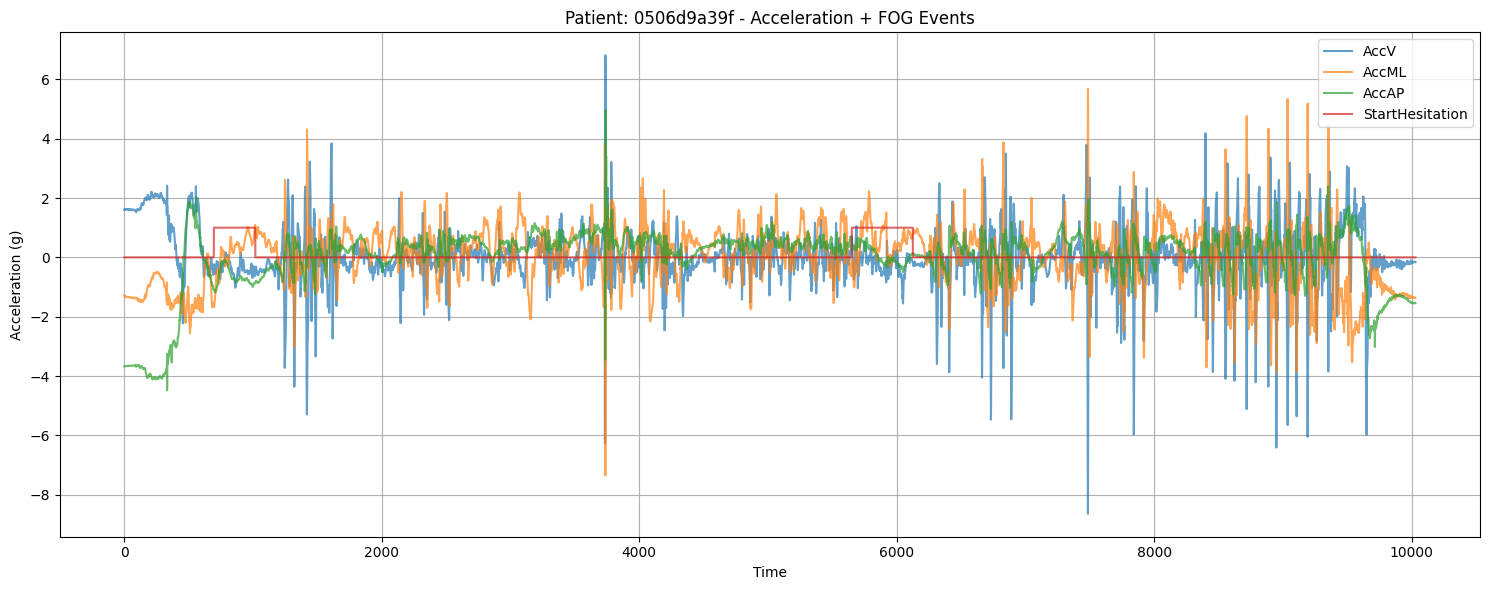

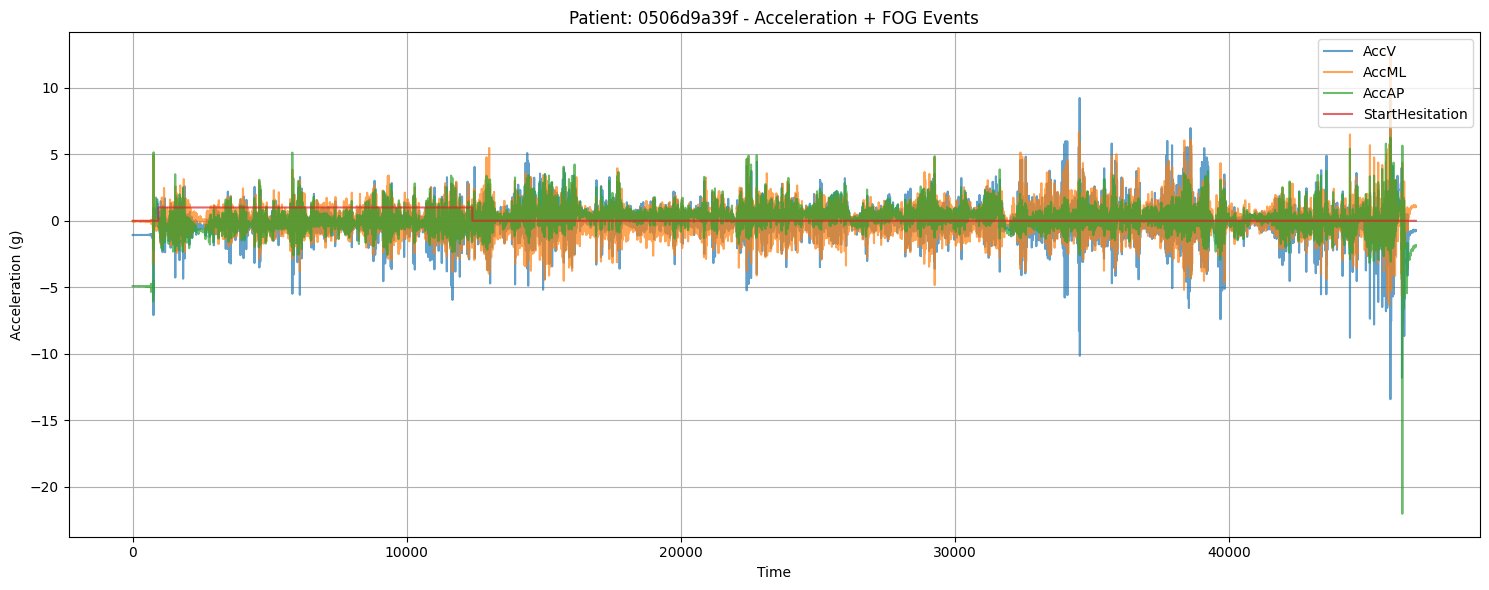

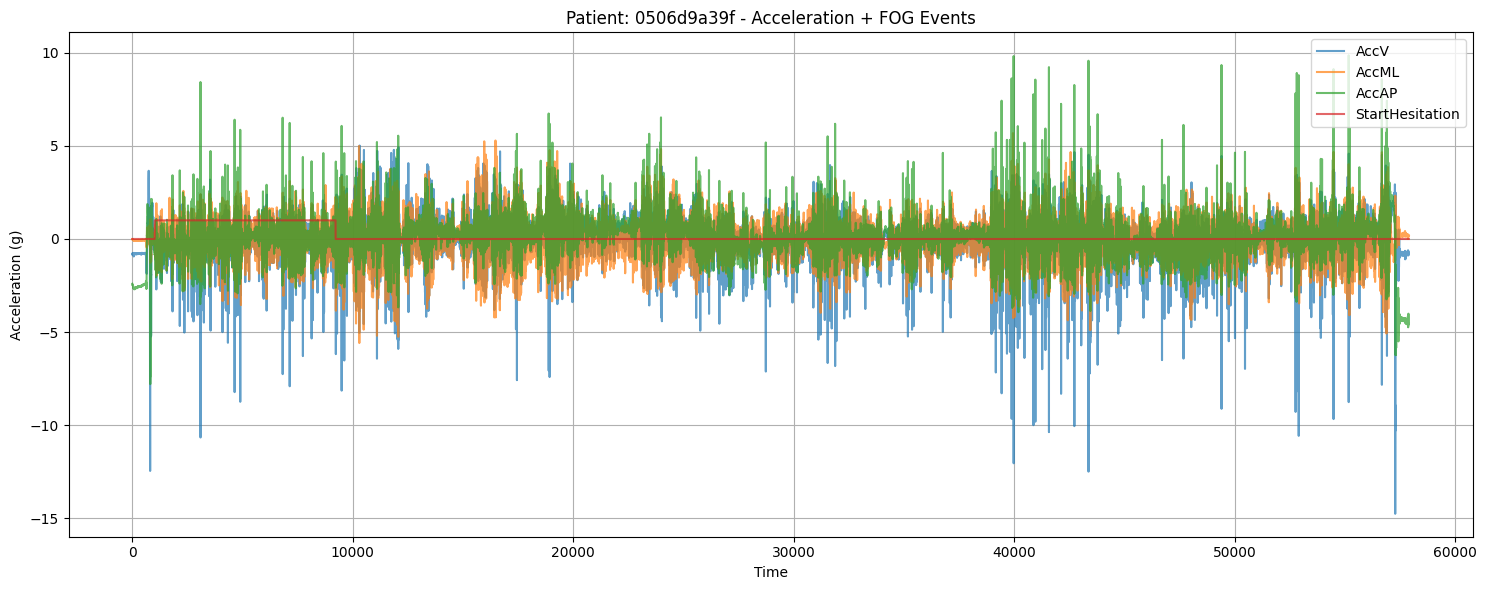

In [49]:
# Start Hestitation
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == '81262644e7').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Start Hestitation
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == '3ba3590a08').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()



# Start Hestitation
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == 'd98358a75f').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

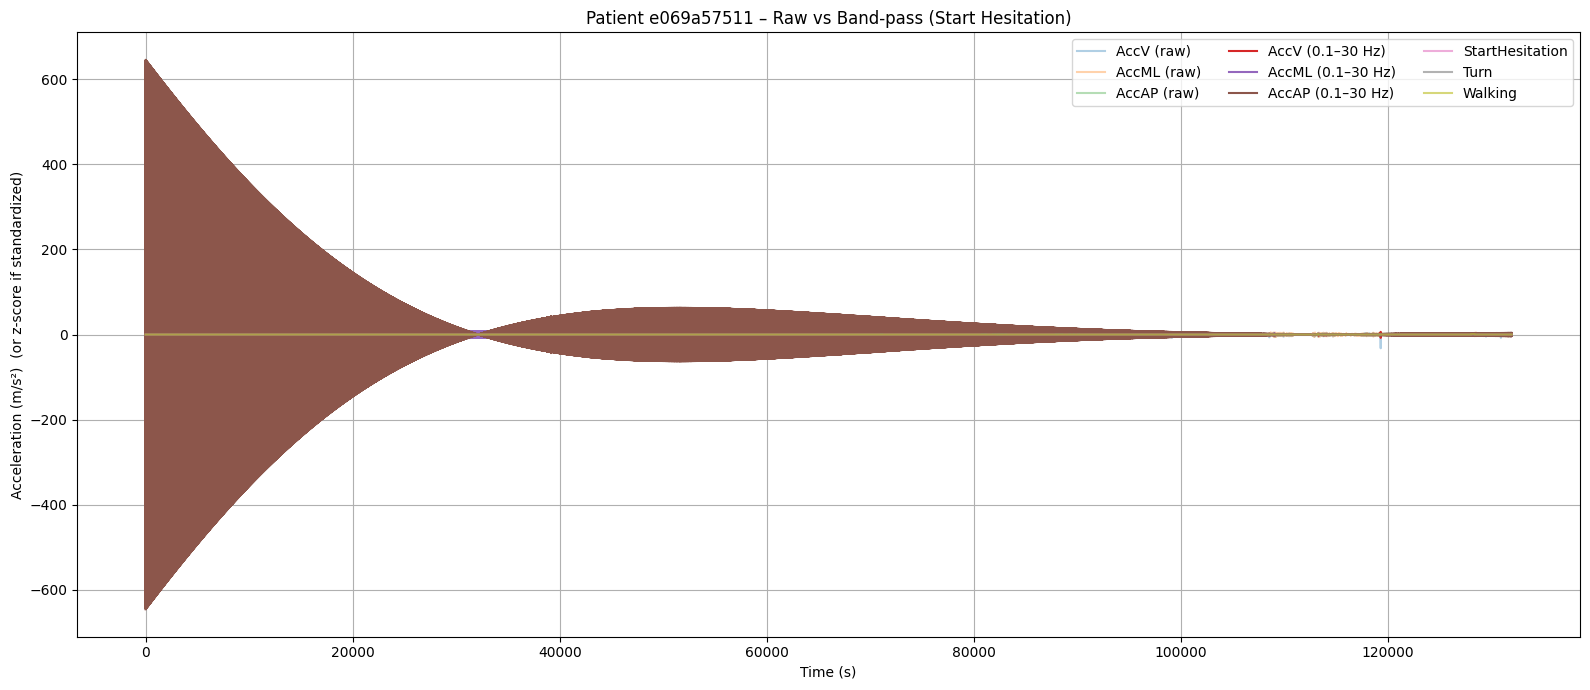

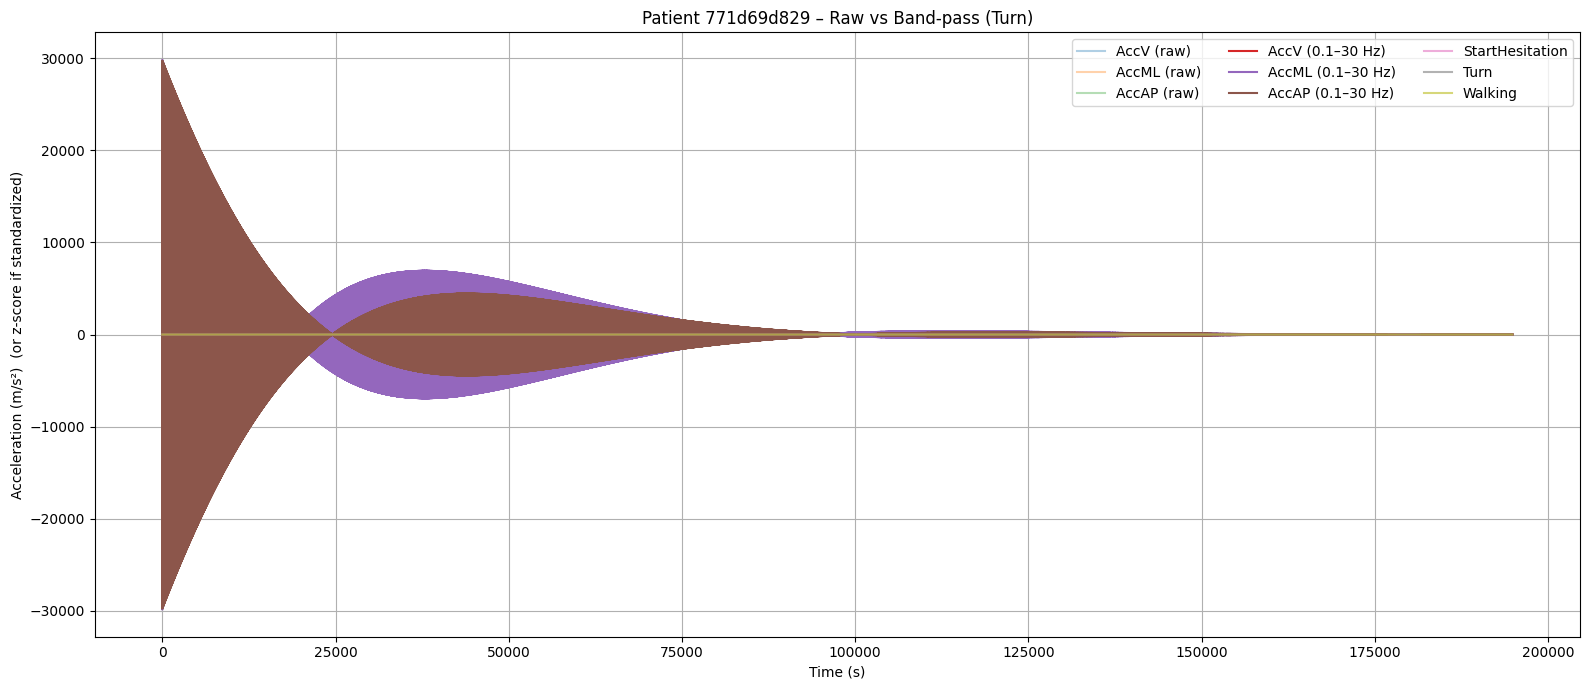

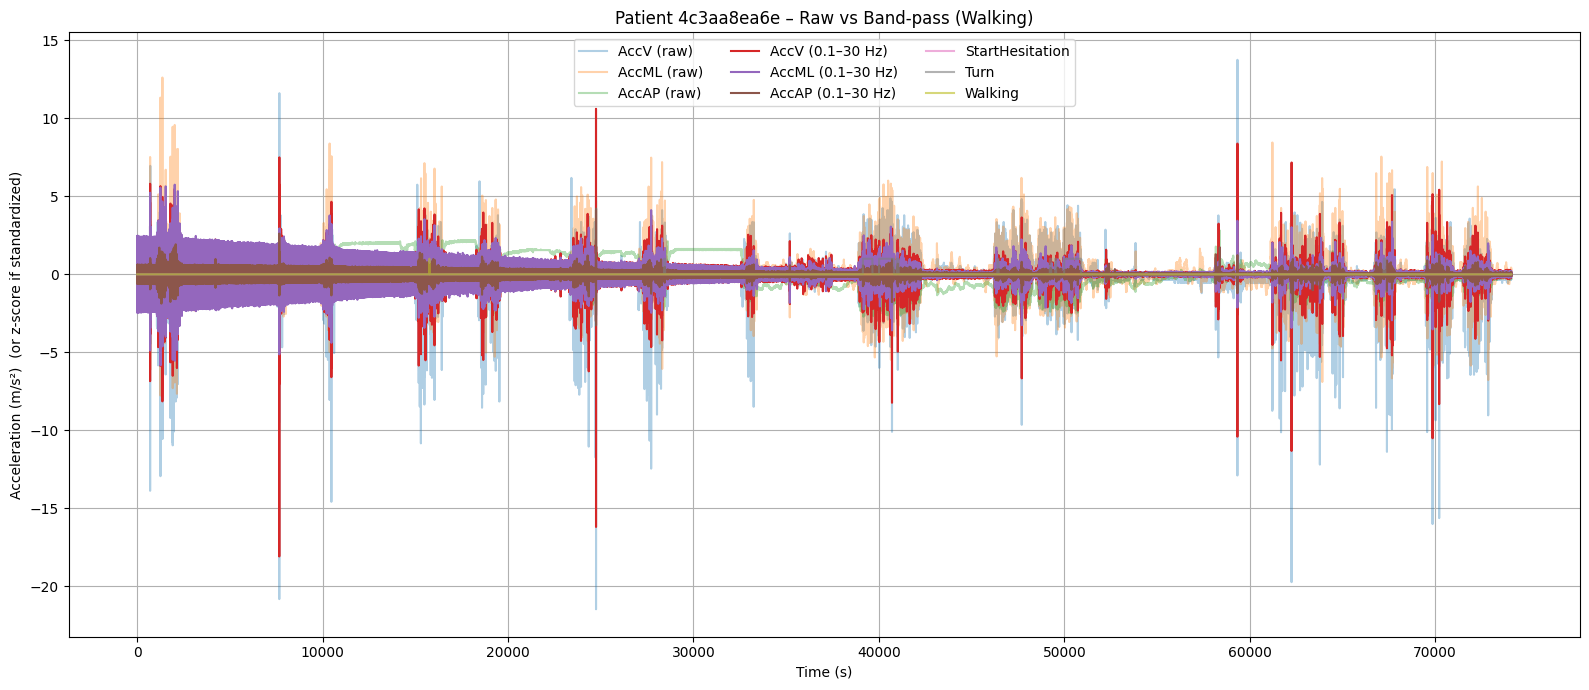

In [50]:
# Patient in defog bp with Start Hesitation 
patient_id = "e069a57511" 
dfp = defog_df_bp.filter(pl.col("patient_id") == patient_id).to_pandas()

plt.figure(figsize=(16,7))

# Raw
plt.plot(dfp["Time"], dfp.get("AccV", pd.Series()),   label="AccV (raw)",   alpha=0.35)
plt.plot(dfp["Time"], dfp.get("AccML", pd.Series()),  label="AccML (raw)",  alpha=0.35)
plt.plot(dfp["Time"], dfp.get("AccAP", pd.Series()),  label="AccAP (raw)",  alpha=0.35)

# Filtered (if present)
if "AccV_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccV_bp"],  label="AccV (0.1–30 Hz)",  linewidth=1.5)
if "AccML_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccML_bp"], label="AccML (0.1–30 Hz)", linewidth=1.5)
if "AccAP_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccAP_bp"], label="AccAP (0.1–30 Hz)", linewidth=1.5)

# Event overlays
for ev in ["StartHesitation", "Turn", "Walking"]:
    if ev in dfp.columns:
        plt.plot(dfp["Time"], dfp[ev], label=ev, alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)  (or z-score if standardized)")
plt.title(f"Patient {patient_id} – Raw vs Band-pass (Start Hesitation)")
plt.legend(ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()

# Patient in defog bp that has turn 
patient_id = "771d69d829" 
dfp = defog_df_bp.filter(pl.col("patient_id") == patient_id).to_pandas()

plt.figure(figsize=(16,7))

# Raw
plt.plot(dfp["Time"], dfp.get("AccV", pd.Series()),   label="AccV (raw)",   alpha=0.35)
plt.plot(dfp["Time"], dfp.get("AccML", pd.Series()),  label="AccML (raw)",  alpha=0.35)
plt.plot(dfp["Time"], dfp.get("AccAP", pd.Series()),  label="AccAP (raw)",  alpha=0.35)

# Filtered (if present)
if "AccV_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccV_bp"],  label="AccV (0.1–30 Hz)",  linewidth=1.5)
if "AccML_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccML_bp"], label="AccML (0.1–30 Hz)", linewidth=1.5)
if "AccAP_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccAP_bp"], label="AccAP (0.1–30 Hz)", linewidth=1.5)

# Event overlays 
for ev in ["StartHesitation", "Turn", "Walking"]:
    if ev in dfp.columns:
        plt.plot(dfp["Time"], dfp[ev], label=ev, alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)  (or z-score if standardized)")
plt.title(f"Patient {patient_id} – Raw vs Band-pass (Turn)")
plt.legend(ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()

# Patient in defog bp that has Walking 
patient_id = "4c3aa8ea6e" 
dfp = defog_df_bp.filter(pl.col("patient_id") == patient_id).to_pandas()

plt.figure(figsize=(16,7))

# Raw
plt.plot(dfp["Time"], dfp.get("AccV", pd.Series()),   label="AccV (raw)",   alpha=0.35)
plt.plot(dfp["Time"], dfp.get("AccML", pd.Series()),  label="AccML (raw)",  alpha=0.35)
plt.plot(dfp["Time"], dfp.get("AccAP", pd.Series()),  label="AccAP (raw)",  alpha=0.35)

# Filtered (if present)
if "AccV_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccV_bp"],  label="AccV (0.1–30 Hz)",  linewidth=1.5)
if "AccML_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccML_bp"], label="AccML (0.1–30 Hz)", linewidth=1.5)
if "AccAP_bp" in dfp:
    plt.plot(dfp["Time"], dfp["AccAP_bp"], label="AccAP (0.1–30 Hz)", linewidth=1.5)

for ev in ["StartHesitation", "Turn", "Walking"]:
    if ev in dfp.columns:
        plt.plot(dfp["Time"], dfp[ev], label=ev, alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)  (or z-score if standardized)")
plt.title(f"Patient {patient_id} – Raw vs Band-pass (Walking)")
plt.legend(ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
ACC_COLS = ['AccV', 'AccML', 'AccAP']

def plot_subject_axes(df: pl.DataFrame, patient_id: str, filtered=True):
    g = df.filter(pl.col("patient_id") == patient_id)

    if g.height == 0:
        print(f"No rows for {patient_id}")
        return

    # Use your new time column
    tcol = "TimeInSeconds" 

    # Sort and drop duplicates by time to avoid “filled” lines
    g = g.sort(tcol).unique(subset=[tcol])

    step = max(1, len(g)//5000)
    g = g[::step]

    cols = [f"{c}_bp" for c in ("AccV","AccML","AccAP")
            if f"{c}_bp" in g.columns] or ACC_COLS

    plt.figure(figsize=(14, 5))
    for c in cols:
        plt.plot(
            g[tcol].to_numpy(),
            g[c].to_numpy(),
            label=c,
            linewidth=0.8,
            alpha=0.8,   # semi-transparent
        )

    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"{patient_id} – Acceleration signals (band passed)" if "_bp" in cols[0] else f"{patient_id} – raw acceleration")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_subject_magnitude(df: pl.DataFrame, patient_id: str, filtered=True):
    g = df.filter(pl.col("patient_id") == patient_id)

    if g.height == 0:
        print(f"No rows for {patient_id}")
        return

    tcol = "TimeInSeconds"
    g = g.sort(tcol).unique(subset=[tcol])
    step = max(1, len(g)//5000)
    g = g[::step]

    if filtered and "AccMag_bp" in g.columns:
        y = g["AccMag_bp"].to_numpy()
        label = "AccMag_bp"
    else:
        y = np.sqrt(g["AccV"].to_numpy()**2 +
                    g["AccML"].to_numpy()**2 +
                    g["AccAP"].to_numpy()**2)
        label = "Acceleration magnitude"

    plt.figure(figsize=(14, 4))
    plt.plot(g[tcol].to_numpy(), y, label=label, linewidth=0.8, alpha=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration magnitude")
    plt.title(f"{patient_id} – {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def small_multiples(df: pl.DataFrame, patient_ids, filtered=True, max_cols=3):
    import math
    n = len(patient_ids)
    rows = math.ceil(n / max_cols)
    cols = min(n, max_cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.2*rows), squeeze=False)

    for i, pid in enumerate(patient_ids):
        r, c = divmod(i, cols)
        ax = axes[r][c]
        g = df.filter(pl.col("patient_id") == pid)
        if g.height == 0:
            ax.set_title(f"{pid} (no data)")
            ax.axis("off")
            continue

        tcol = "TimeInSeconds"
        g = g.sort(tcol)
        to_plot = [f"{k}_bp" for k in ACC_COLS] if filtered and all(f"{k}_bp" in g.columns for k in ACC_COLS) else list(ACC_COLS)
        for col in to_plot:
            ax.plot(g[tcol].to_numpy(), g[col].to_numpy(), linewidth=0.8, label=col)
        ax.set_title(pid)
        ax.set_xlabel("s"); ax.set_ylabel("acc")
        if i == 0:
            ax.legend(fontsize=8)

    for j in range(n, rows*cols):
        r, c = divmod(j, cols)
        axes[r][c].axis("off")
    fig.suptitle("Acceleration signals for multiple patients", y=1.02)
    fig.tight_layout()
    plt.show()

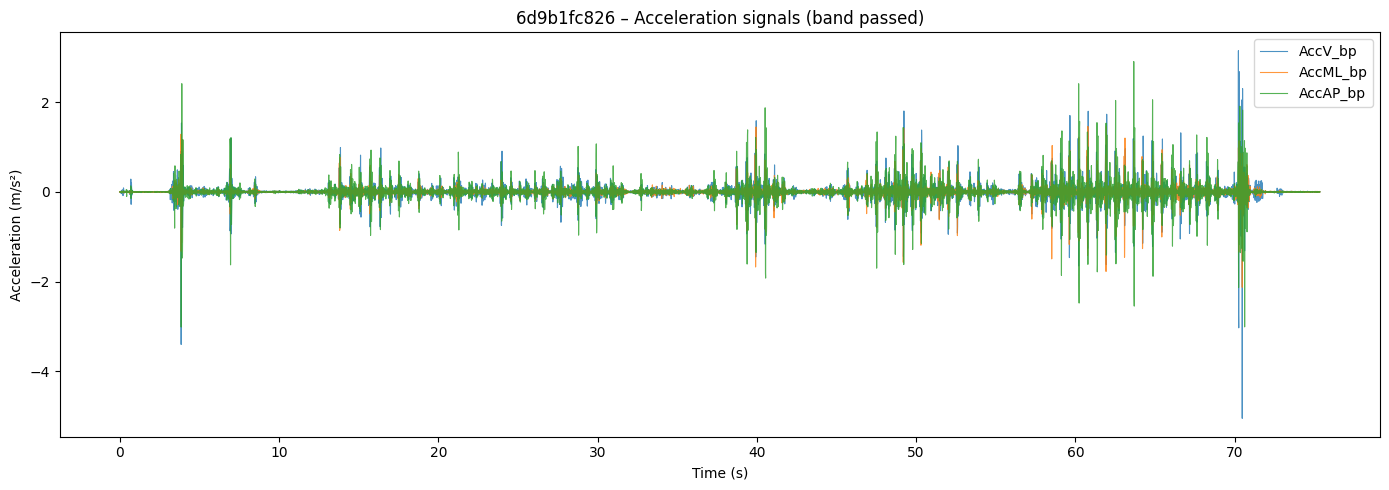

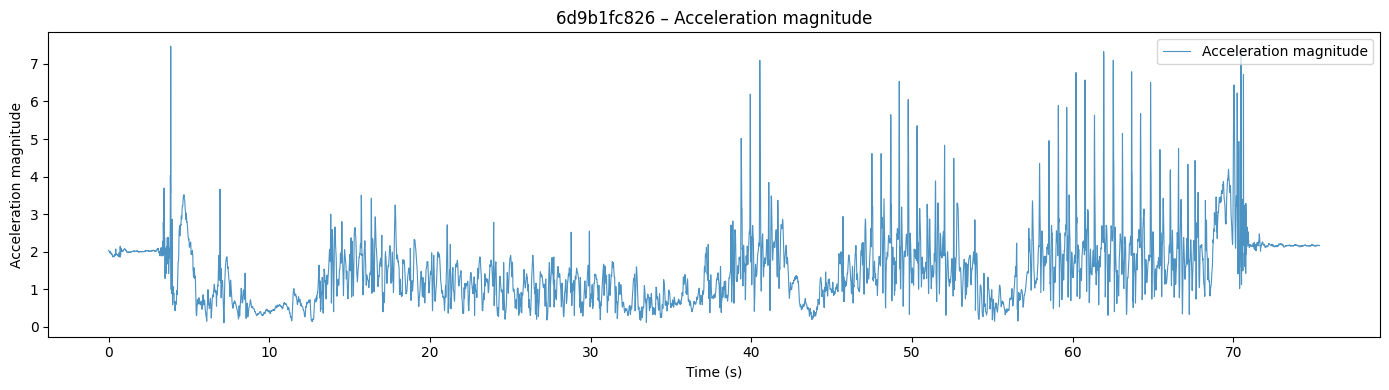

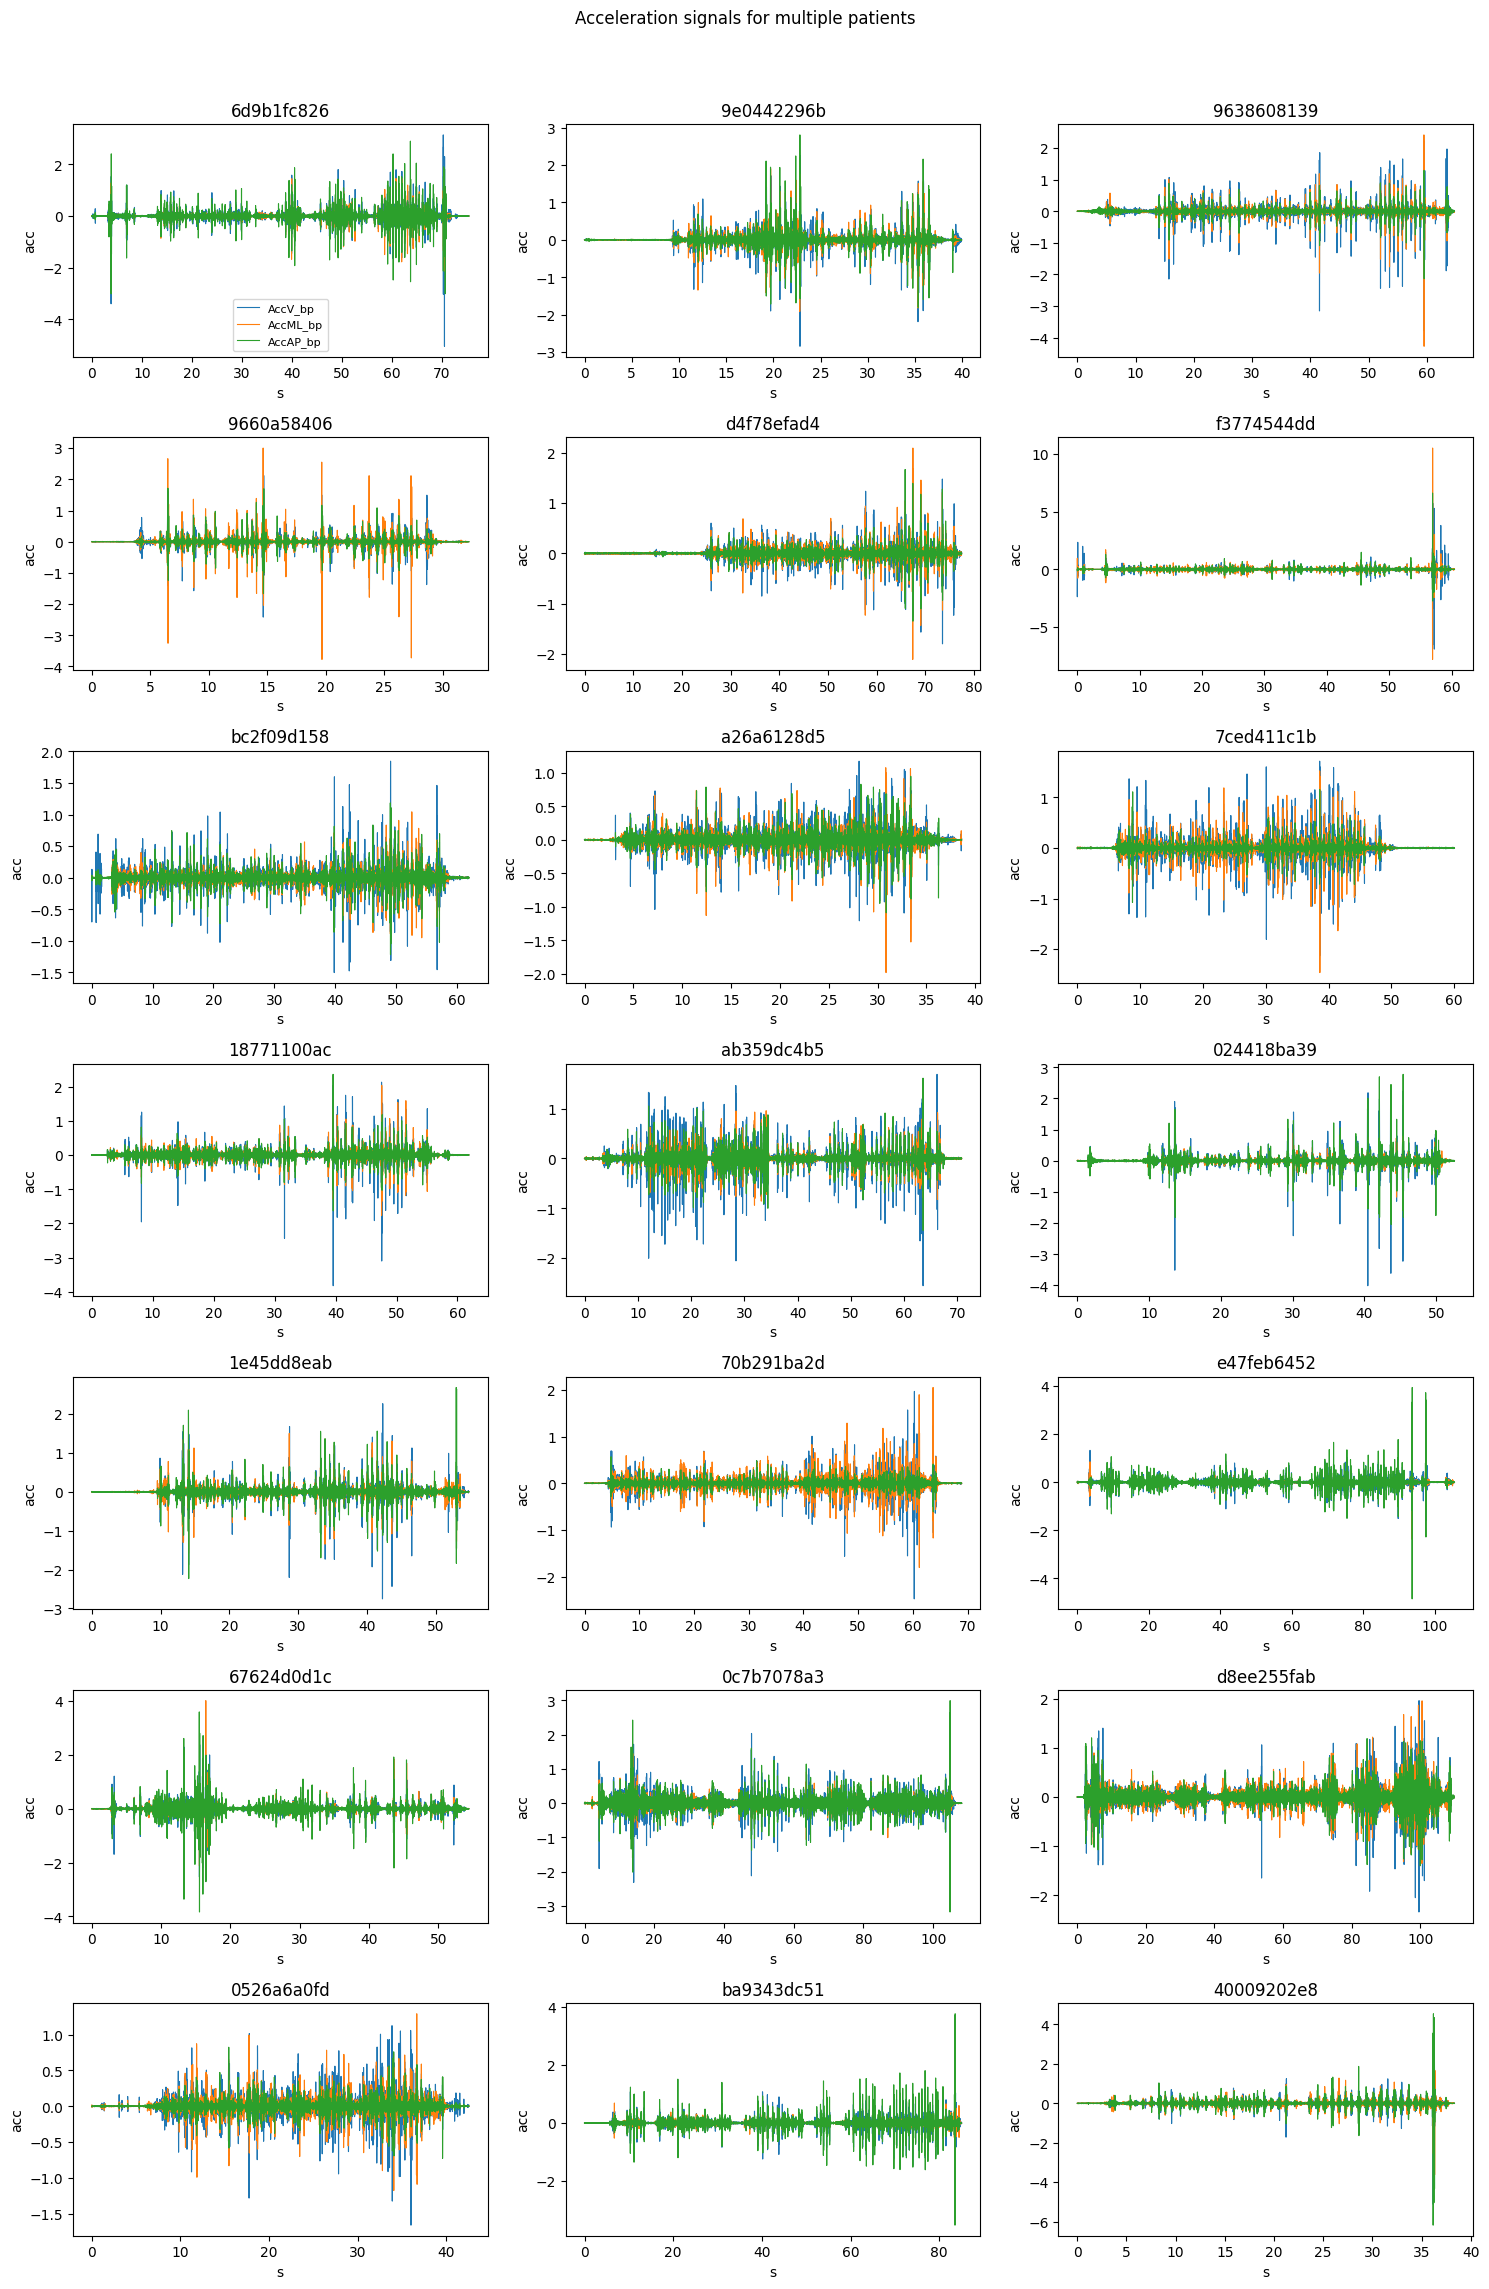

In [126]:
all_patients = defog_df_bp.select("patient_id").unique().to_series().to_list()

# one subject, 3 axes + magnitude (band-passed)
example_pid = all_patients[0]
plot_subject_axes(defog_df_bp, example_pid, filtered=True)
plot_subject_magnitude(defog_df_bp, example_pid, filtered=True)

# small-multiples: first 21 subjects
subset = all_patients[:21]
small_multiples(defog_df_bp, subset, filtered=True)